<h2>Import Modules</h2>

In [22]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from vessel_scoring import  utils

(1623,
 5,
 [-179.99999999999997, -15.38614238799994, 0.0, 0.0],
 [180.0000000000001, 74.70741753800007, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x1250a2750>)

In [ ]:
fig = plt.figure(figsize=(15,5))
map = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=50,resolution='c')

map.readshapefile('/Users/edwardkerrigan/Downloads/mpa_inventory_2014_public_shp/mpa_inventory_2014_public_shp',
                   'mpa_inventory_2014_public_shp')
#plt.show()


map.readshapefile('/Users/edwardkerrigan/Downloads/USMaritimeLimitsAndBoundariesSHP/USMaritimeLimitsNBoundaries',
                  'USMaritimeLimitsAndBoundariesSHP')

<h2>Data Pre-Processing</h2>

In [2]:
#Load all the data into numpy arrays
longliner_data = np.load('datasets/measures/kristina_longliner.measures.npz')
trawl_data = np.load('datasets/measures/kristina_trawl.measures.npz')
ps_data = np.load('datasets/measures/kristina_ps.measures.npz')

#Move _data['x'][:] into _x[:] 
longliner_data = longliner_data['x']
trawl_data = trawl_data['x']
ps_data = ps_data['x']

#Convert into Pandas data frame
longliner_data = pd.DataFrame(longliner_data)
trawl_data = pd.DataFrame(trawl_data)
ps_data = pd.DataFrame(ps_data)

In [23]:
#Build a dataframe with all the data
frames=[longliner_data, trawl_data, ps_data]
all_data = pd.concat(frames).copy()

#drop unknown fishing points
longliner_data['classification'].astype(int)
longliner_data = longliner_data[longliner_data['classification'] != -1]
trawl_data['classification'].astype(int)
trawl_data = trawl_data[trawl_data['classification'] != -1]
ps_data['classification'].astype(int)
ps_data = ps_data[ps_data['classification'] != -1]
all_data['classification'].astype(int)


#drop duplicate rows
longliner_data.drop_duplicates()
trawl_data.drop_duplicates()
ps_data.drop_duplicates()


measure_coursestddev_1800_log  measure_courseavg_43200      course  \
8953                         -2.999746                 0.463714  165.300003   
9065                         -2.999681                 0.505093  130.100006   
9067                         -1.963659                 0.495833  128.500000   
9089                         -2.317412                 0.519268  187.199997   
9117                         -2.999842                 0.561921  343.100006   
9183                         -3.000000                 0.505417  243.899994   
9185                         -2.108592                 0.518889  245.000000   
9187                         -2.183775                 0.530337  244.500000   
9189                         -2.999658                 0.567821  104.300003   
9217                         -2.999746                 0.691894   14.400000   
9219                         -0.693745                 0.645231   47.500000   
9225                         -2.999695                 0.600214  140.300003   
9243                         -2.999692                 0.325031  138.300003   
9245                         -2.015978                 0.330556  136.899994   
9247                         -1.929068                 0.334899  136.199997   
9249                         -1.966179                 0.338866  137.699997   
9251                         -2.008035                 0.342094  137.100006   
9263                         -2.999667                 0.410985   62.799999   
9265                         -1.035960                 0.381303   78.500000   
9269                         -1.089027                 0.359981   79.699997   
9273                         -1.112925                 0.344428   82.000000   
9277                         -1.023334                 0.327120   64.800003   
9281                         -0.971382                 0.312209   61.400002   
9285                         -1.002705                 0.303297   75.500000   
9311                         -2.999659                 0.363000   71.699997   
9313                         -2.999758                 0.351255   73.599998   
9317                         -1.331323                 0.342548   81.000000   
9345                         -2.999755                 0.180880   87.800003   
9349                         -1.277471                 0.184847   79.400002   
9353                         -1.307543                 0.190164   87.599998   
...                                ...                      ...         ...   
1030929                      -2.086498                 0.856438  337.799988   
1030943                      -2.999951                 0.936021  332.899994   
1030947                      -1.916975                 0.935185  331.100006   
1030951                      -1.917249                 0.934404  330.899994   
1030955                      -1.969919                 0.933824  331.899994   
1030959                      -2.011117                 0.933296  331.899994   
1030963                      -2.028612                 0.932730  331.200012   
1030967                      -2.054678                 0.932234  331.399994   
1030971                      -2.999927                 0.923083  331.200012   
1030985                      -2.999925                 0.920688  329.799988   
1031063                      -2.034679                 0.922650  330.899994   
1031079                      -2.999923                 0.923130  333.899994   
1031135                      -2.999941                 0.921846  328.899994   
1031139                      -1.916968                 0.921506  330.700012   
1031143                      -1.951044                 0.920780  329.000000   
1031147                      -1.998158                 0.920399  329.899994   
1031151                      -2.019019                 0.920144  330.200012   
1031155                      -2.010213                 0.920010  330.600006   
1031177                      -2.999923                 0.91

<h2>Data Visualization</h2>

In [24]:
#Separate data and Plot Histogram 
#Separate out tracks marked not fishing
not_fishing_all = all_data.loc[all_data['classification'] == 0]

#Separate out tracks marked fishing
fishing_all = all_data.loc[all_data['classification']==1]

#Separate out unidentified tracks
unknown_sailing_all = all_data.loc[all_data['classification']==-1]

#remove duplicates
#xpd_sorted_no_dups=xpd_sorted.copy
all_data_no_dups = all_data.drop_duplicates(subset=['timestamp', 'classification'])
#Separate out tracks marked not fishing
not_fishing = all_data_no_dups.loc[all_data_no_dups['classification']==0]

#Separate out tracks marked fishing
fishing = all_data_no_dups.loc[all_data_no_dups['classification']==1]

#Separate out unidentified tracks
unknown_sailing = all_data_no_dups.loc[all_data_no_dups['classification']==-1]



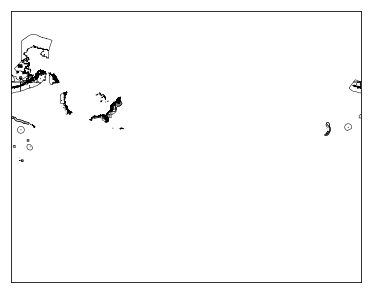

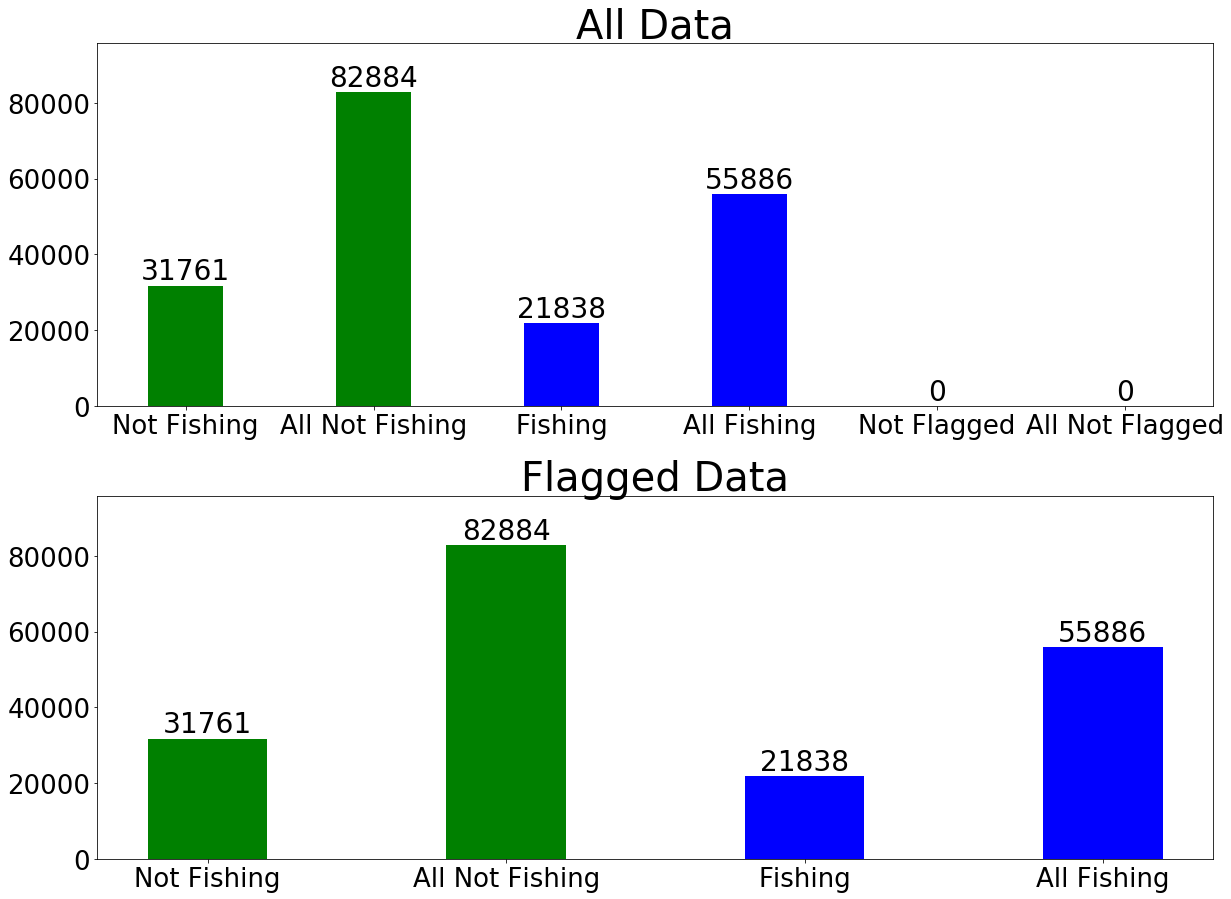

In [25]:
plt.rcParams.update({'font.size': 26})
#-----------------------------------------------------------------------------------------
#     Plot Histogram of all data
#-----------------------------------------------------------------------------------------
counts = [len(not_fishing.index),len(not_fishing_all.index),  
          len(fishing.index), len(fishing_all.index),
          len(unknown_sailing.index),len(unknown_sailing_all.index)]
N = len(counts)

x_labels = ['Not Fishing', 'All Not Fishing', 'Fishing','All Fishing', 'Not Flagged', 'All Not Flagged']
x = range(N)
width=0.4
fig = plt.figure(figsize=(20,15))
ax=plt.subplot(211)
fig.subplots_adjust(hspace=.25)
ax.set_title('All Data', fontsize=40)
ax.bar(x, counts, width=width, color= ['g','g','b','b','c','c'])
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x_labels,rotation=0)
ax.set_ybound(upper=ax.get_ylim()[1]*1.1)
rects = ax.patches
for rect, label in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label,  ha='center', 
             va='bottom', color='black', fontsize=28)

counts2 = [len(not_fishing.index),len(not_fishing_all.index),  
          len(fishing.index), len(fishing_all.index)]
N2 = len(counts2)
x2_labels = ['Not Fishing', 'All Not Fishing', 'Fishing','All Fishing']
x2 = range(N2)
ax2=plt.subplot(212)
ax2.set_title('Flagged Data', fontsize=40)
ax2.bar(x2, counts2, width=width, color= ['g','g','b','b'])
ax2.set_xticks(np.arange(len(x2)))
ax2.set_xticklabels(x2_labels, rotation =0)

ax2.set_ybound(upper=ax2.get_ylim()[1]*1.1)
rects = ax2.patches
for rect, label in zip(rects, counts2):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 5, label,  ha='center', 
             va='bottom', color='black', fontsize=28)
plt.show()

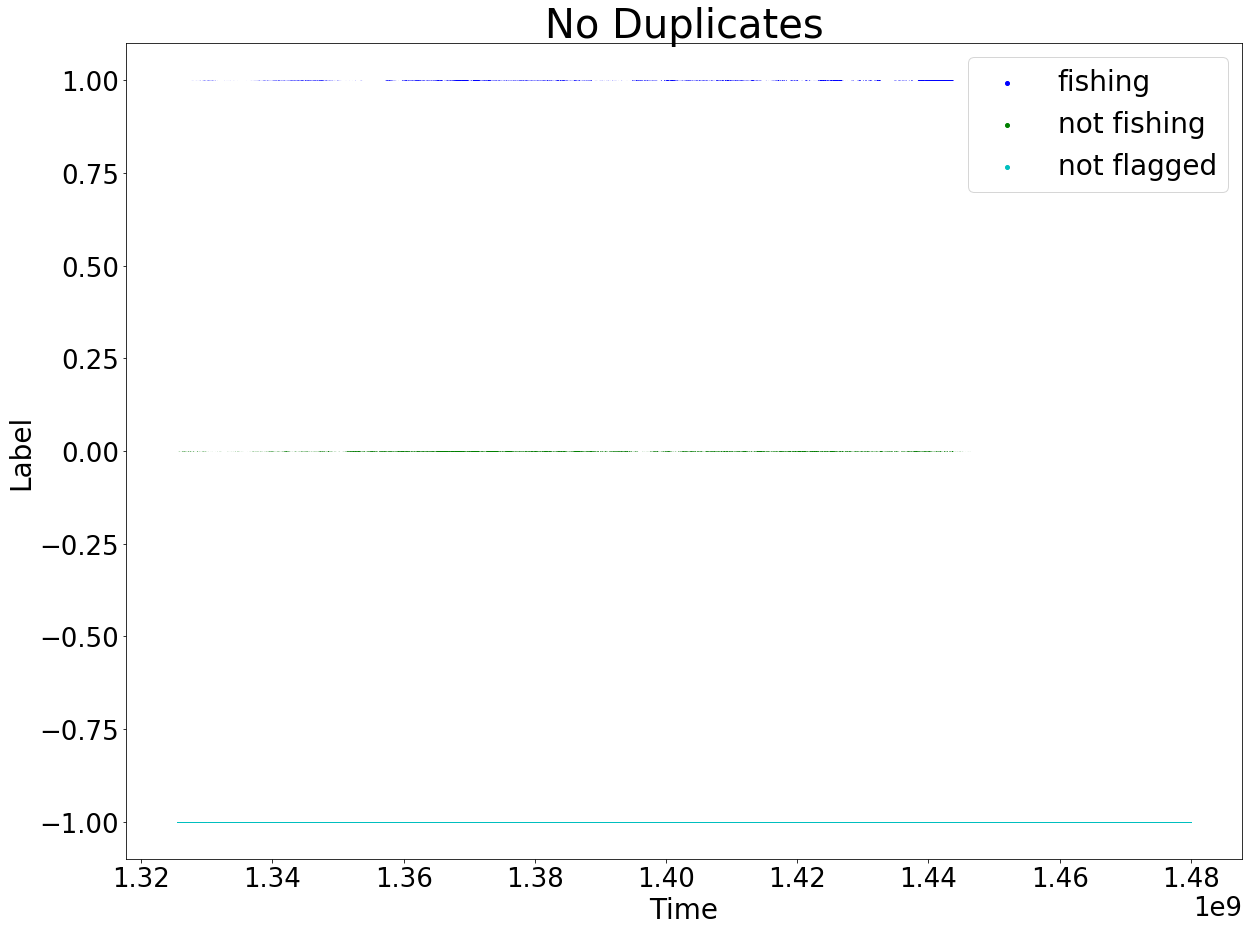

In [6]:
#-----------------------------------------------------------------------------------------
#     Scatter Plot of data flags
#-----------------------------------------------------------------------------------------
plt.figure(figsize=(20,15))
axs1 = plt.axes()
axs1.set_title('No Duplicates', fontsize=40)
axs1.scatter(fishing.timestamp, fishing.classification, color='b',s=.0001,label='fishing')
axs1.scatter(not_fishing.timestamp, not_fishing.classification, color='g',s=.0001,label='not fishing')
axs1.scatter(unknown_sailing.timestamp, unknown_sailing.classification, color='c',s=.0001,label='not flagged')
#axs1.scatter(all_data_no_dups.timestamp, all_data_no_dups.classification,s=1)
#axs1.text(np.asscalar(all_data_no_dups['timestamp'].as_matrix()[:1]), 
#          -0.5, ' 1 - Fishing\n 0 - Not Fishing\n-1 - Not Labeled',
#         bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
axs1.axes.set_xlabel('Time', fontsize=28)
axs1.axes.set_ylabel('Label', fontsize=28)
plt.legend(loc=0, markerscale=400,fontsize=28)
plt.show()

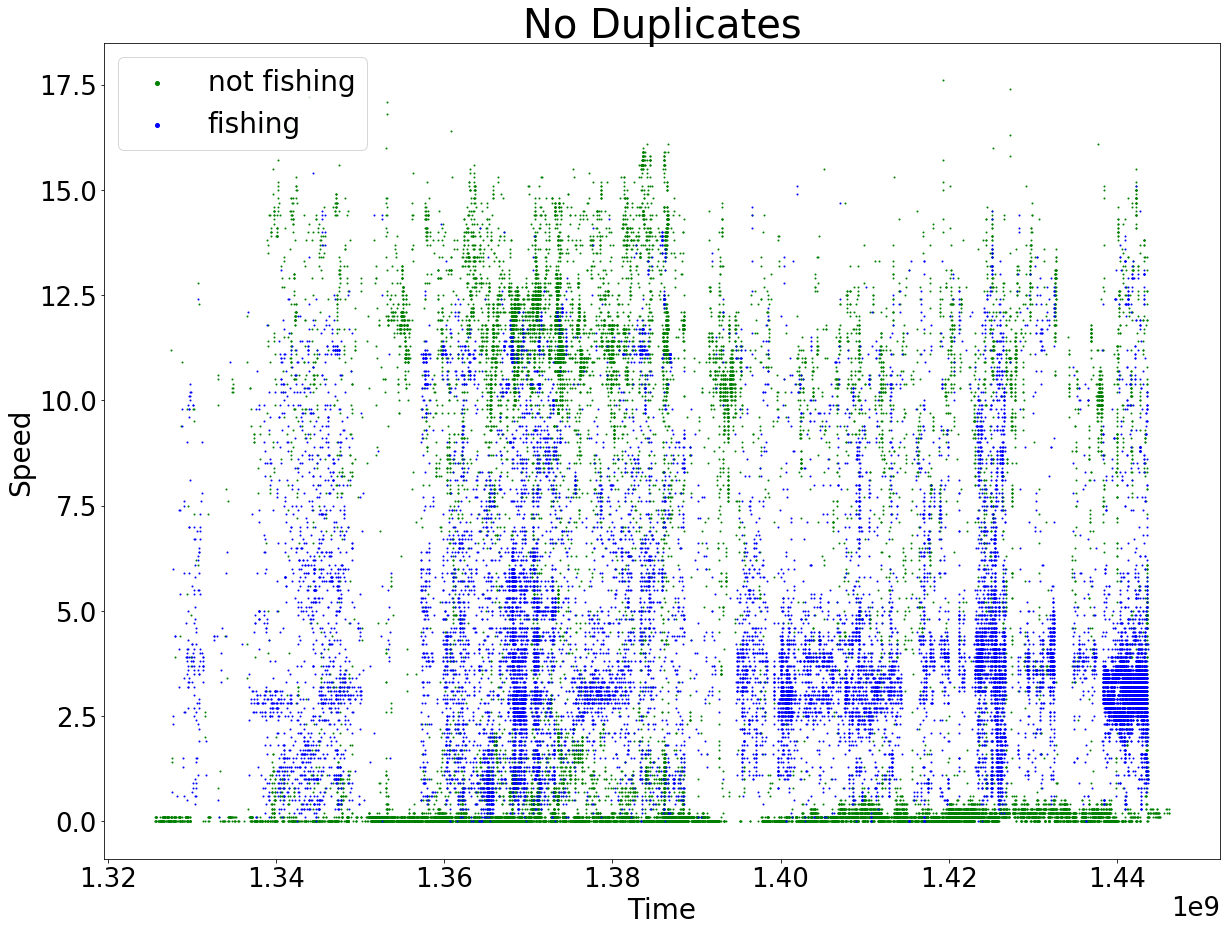

In [7]:
#-----------------------------------------------------------------------------------------
#      Plot Speed no duplicates
#-----------------------------------------------------------------------------------------

#Scatter Plot of Speed
plt.figure(figsize=(20,15))
axs1 = plt.subplot(111)
plt.title('No Duplicates', fontsize=40)
plt.scatter(not_fishing.timestamp, not_fishing.speed, s=1, color='g', label='not fishing')
plt.scatter(fishing.timestamp, fishing.speed, s=1, color='b', label='fishing')
plt.xlabel('Time', fontsize=28)
axs1.axes.set_ylabel('Speed', fontsize=28)
plt.legend(loc=0, markerscale=4,fontsize=28)
plt.show()

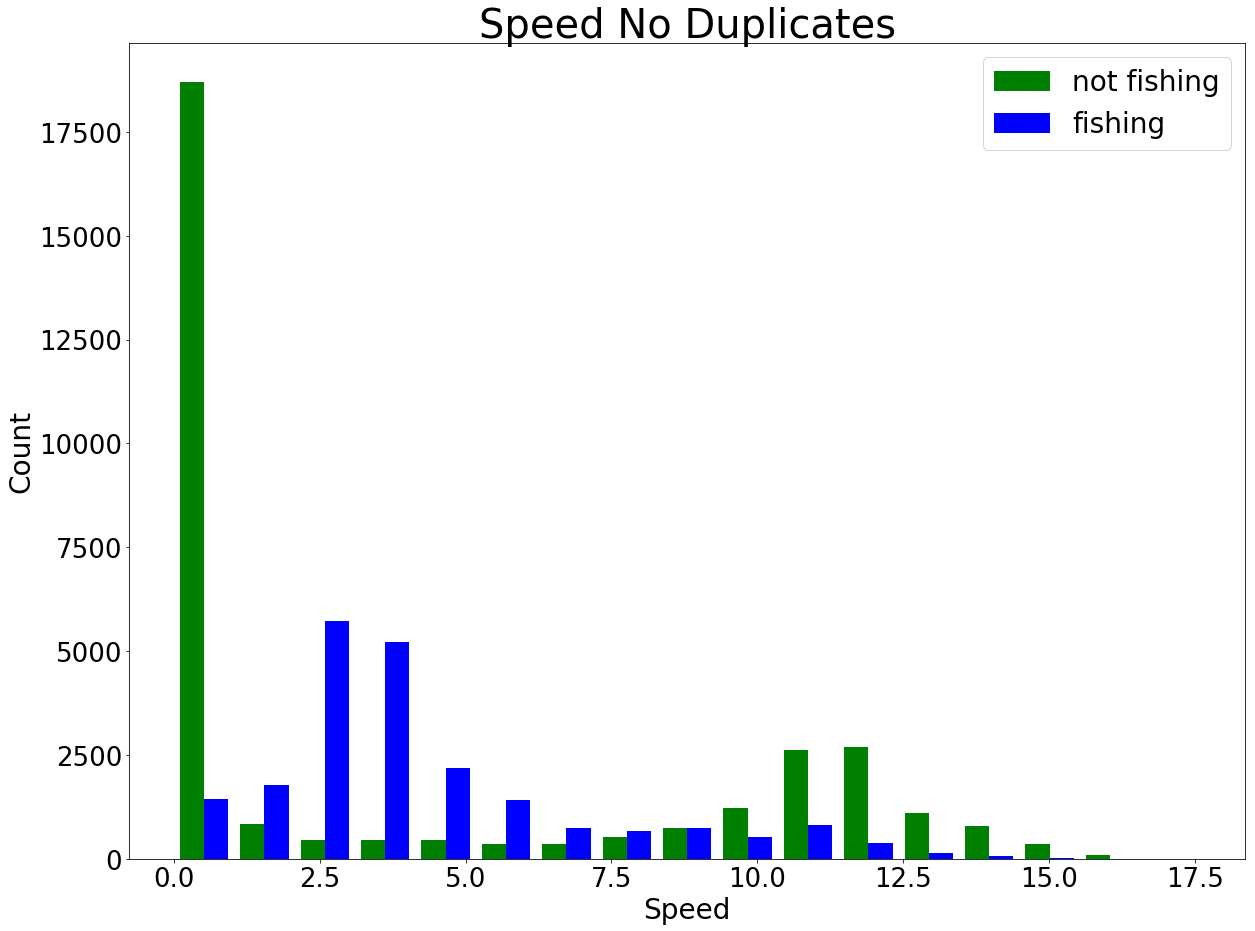

In [8]:
#-----------------------------------------------------------------------------------------
#      Histogram Speed no duplicates
#-----------------------------------------------------------------------------------------

#Histogram Plot of Course
plt.figure(figsize=(20,15))
axs1 = plt.subplot(111)
plt.title('Speed No Duplicates', fontsize=40)
plt.hist([not_fishing.speed, fishing.speed],color= ['g','b'],bins = 17, label=['not fishing', 'fishing'])
axs1.axes.set_xlabel('Speed', fontsize=28)
axs1.axes.set_ylabel('Count', fontsize=28)
plt.legend(loc=0, markerscale=4,fontsize=28)
plt.show()


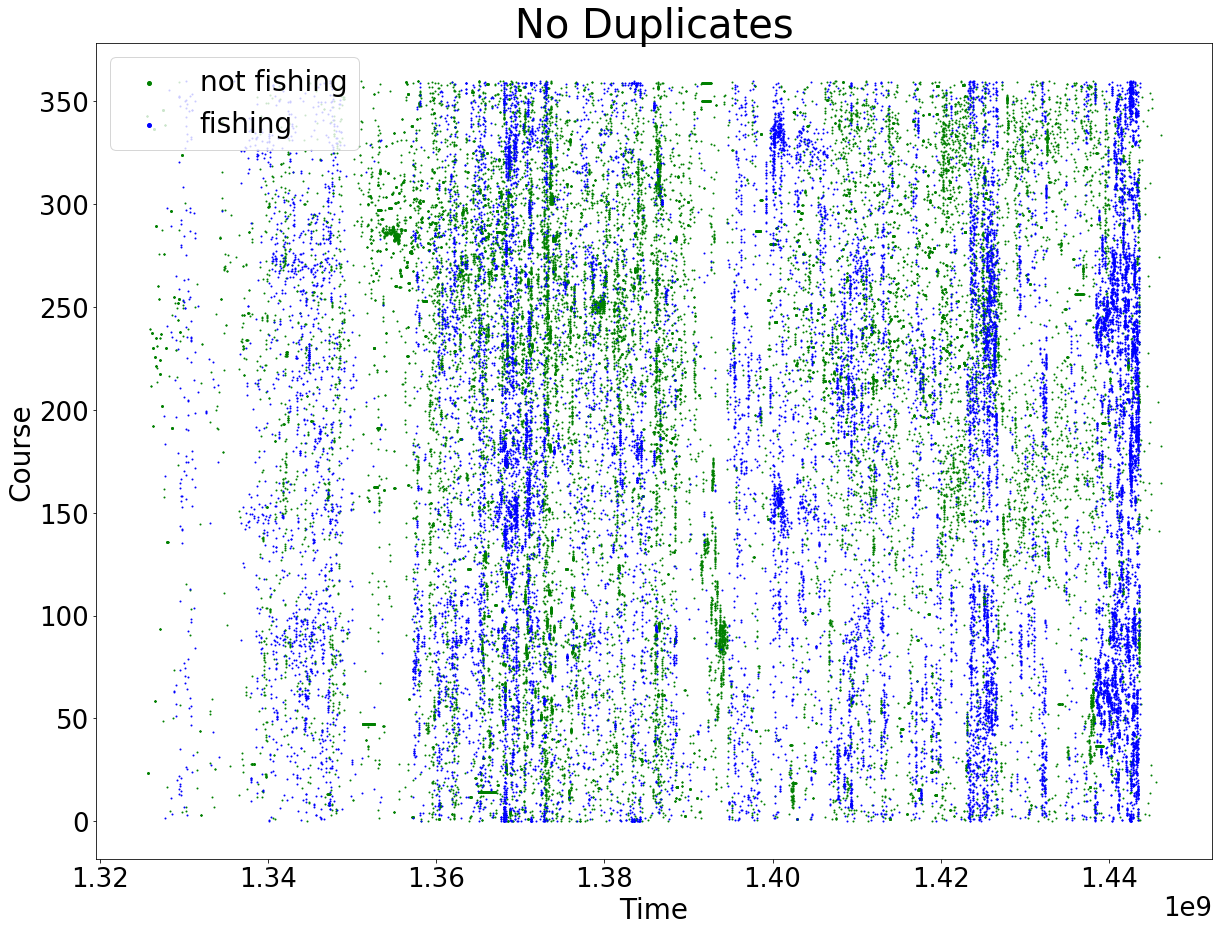

In [9]:
#-----------------------------------------------------------------------------------------
#      Plot Course no duplicates
#-----------------------------------------------------------------------------------------

#Scatter Plot of Course
plt.figure(figsize=(20,15))
axs1 = plt.subplot(111)
plt.title('No Duplicates', fontsize=40)
plt.scatter(not_fishing.timestamp, not_fishing.course, s=1, color='g', label='not fishing')
plt.scatter(fishing.timestamp, fishing.course, s=1, color='b', label='fishing')
plt.xlabel('Time', fontsize=28)
axs1.axes.set_ylabel('Course', fontsize=28)
plt.legend(loc=0, markerscale=4,fontsize=28)
plt.show()

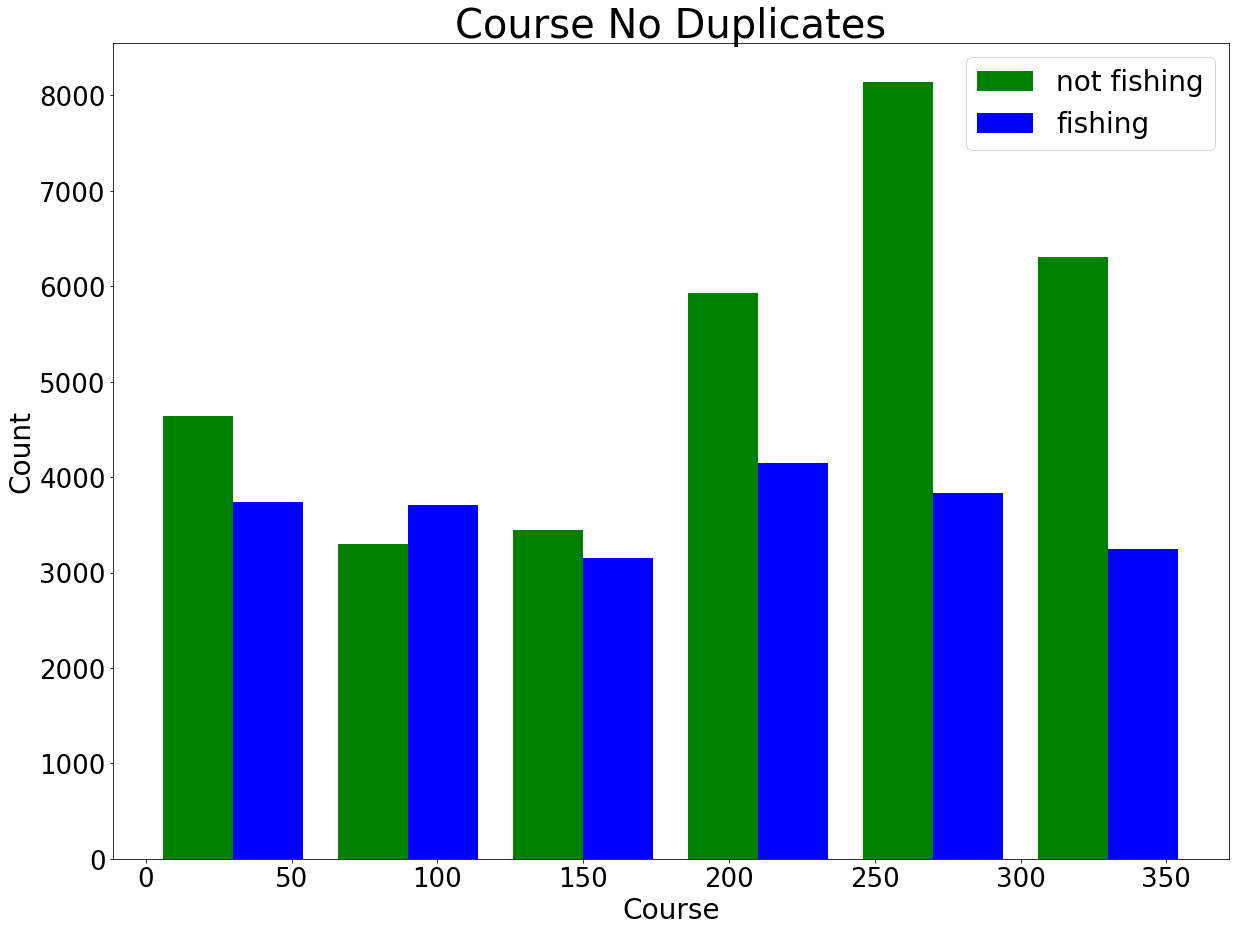

In [10]:
#-----------------------------------------------------------------------------------------
#      Histogram Course no duplicates
#-----------------------------------------------------------------------------------------

#Histogram Plot of Course
plt.figure(figsize=(20,15))
axs1 = plt.subplot(111)
plt.title('Course No Duplicates', fontsize=40)
plt.hist([not_fishing.course, fishing.course],color= ['g','b'],bins = 6, label=['not fishing', 'fishing'])
axs1.axes.set_xlabel('Course', fontsize=28)
axs1.axes.set_ylabel('Count', fontsize=28)
plt.legend(loc=0, markerscale=4,fontsize=28)
plt.show()

pd.options.display.max_columns = 90

#print(ps_data.count)

#pd.options.display.max_columns = 20
#pd.options.display.max_rows= 60
pd.options.display.max_columns
print(ps_data.columns)

In [11]:
pd.options.display.max_columns = 90
all_data.describe()


measure_coursestddev_1800_log  measure_courseavg_43200        course  \
count                   3.627217e+06             3.627217e+06  3.627217e+06   
mean                   -1.530254e+00             5.445073e-01  1.956813e+02   
std                     9.348559e-01             2.035671e-01  1.076038e+02   
min                    -3.000000e+00            -6.643908e-12  0.000000e+00   
25%                    -2.137758e+00             4.111516e-01  9.700000e+01   
50%                    -1.445791e+00             5.508767e-01  2.079000e+02   
75%                    -7.493084e-01             6.911252e-01  2.843000e+02   
max                    -1.499012e-01             1.326235e+00  5.110000e+02   

       measure_sin_course  measure_daylightavg_900  measure_speedstddev_10800  \
count        3.627217e+06             3.627217e+06               3.627217e+06   
mean        -6.662606e-02             4.874547e-01               5.357265e-02   
std          4.974224e-01             4.998427e-01               7.591049e-02   
min         -7.071068e-01             0.000000e+00               0.000000e+00   
25%         -5.669410e-01             0.000000e+00               2.941177e-03   
50%         -6.408706e-02             0.000000e+00               1.663781e-02   
75%          4.045682e-01             1.000000e+00               7.790287e-02   
max          7.071068e-01             1.000000e+00               5.000000e-01   

              speed  measure_pos_86400  measure_daylightavg_43200  \
count  3.627217e+06       3.627217e+06               3.627217e+06   
mean   5.084318e+00       1.103020e+00               7.349491e-02   
std    5.422909e+00       9.935525e+00               2.609472e-01   
min    0.000000e+00       0.000000e+00               0.000000e+00   
25%    2.000000e-01       4.281071e-02               0.000000e+00   
50%    3.100000e+00       2.517613e-01               0.000000e+00   
75%    1.030000e+01       6.868037e-01               0.000000e+00   
max    1.023000e+02       1.799669e+02               1.000000e+00   

       measure_latavg_86400  measure_lonavg_3600  measure_lonavg_1800  \
count          3.627217e+06         3.627217e+06         3.627217e+06   
mean           2.836217e+01        -9.671760e-01        -9.669359e-01   
std            2.953910e+01         1.166907e+02         1.167021e+02   
min           -4.638224e+01        -1.800000e+02        -1.800000e+02   
25%           -1.165879e-01        -1.162962e+02        -1.162971e+02   
50%            2.814160e+01        -8.648376e+00        -8.648352e+00   
75%            5.979268e+01         1.386151e+02         1.386298e+02   
max            7.731174e+01         1.799929e+02         1.799929e+02   

       measure_courseavg_10800  measure_courseavg_1800  \
count             3.627217e+06            3.627217e+06   
mean              5.432576e-01            5.434493e-01   
std               2.377806e-01            2.692193e-01   
min              -2.857788e-12           -3.855791e-12   
25%               3.677910e-01            3.125000e-01   
50%               5.557639e-01            5.653472e-01   
75%               7.273737e-01            7.583263e-01   
max               1.419444e+00            1.419444e+00   

       measure_speedstddev_86400     timestamp  measure_coursestddev_86400  \
count               3.627217e+06  3.627223e+06                3.627217e+06   
mean                1.344209e-01  1.431739e+09                5.034181e-01   
std                 1.086982e-01  3.893438e+07                2.228099e-01   
min                 0.000000e+00  1.325396e+09                0.000000e+00   
25%                 1.778258e-02  1.406963e+09                3.984725e-01   
50%                 1.388581e-01  1.443837e+09                5.983175e-01   
75%                 2.113060e-01  1.463244e+09                6.772026e-01   
max                 5.000000e-01  1.480050e+09                7.071068e-01   

       measure_speedstddev_21600  measure_daylightavg_3600 

#print(ps_data.columns)
plt.figure(figsize=(20,15))
axs1 = plt.subplot(111)
plt.title('measure_count_21600', fontsize=20)
plt.scatter(all_data.timestamp[:2000], all_data.measure_daylightavg_21600[:2000])
plt.show()

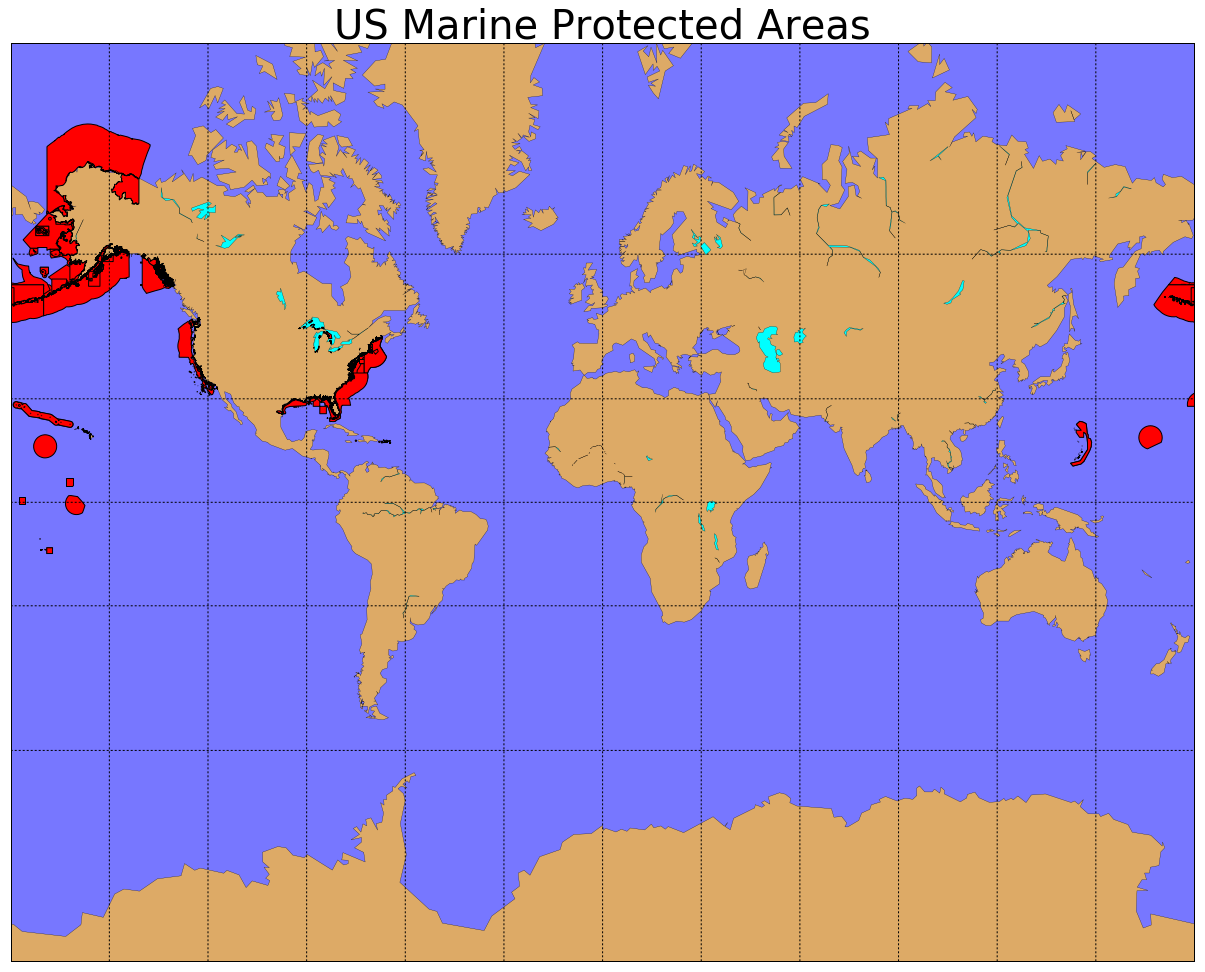

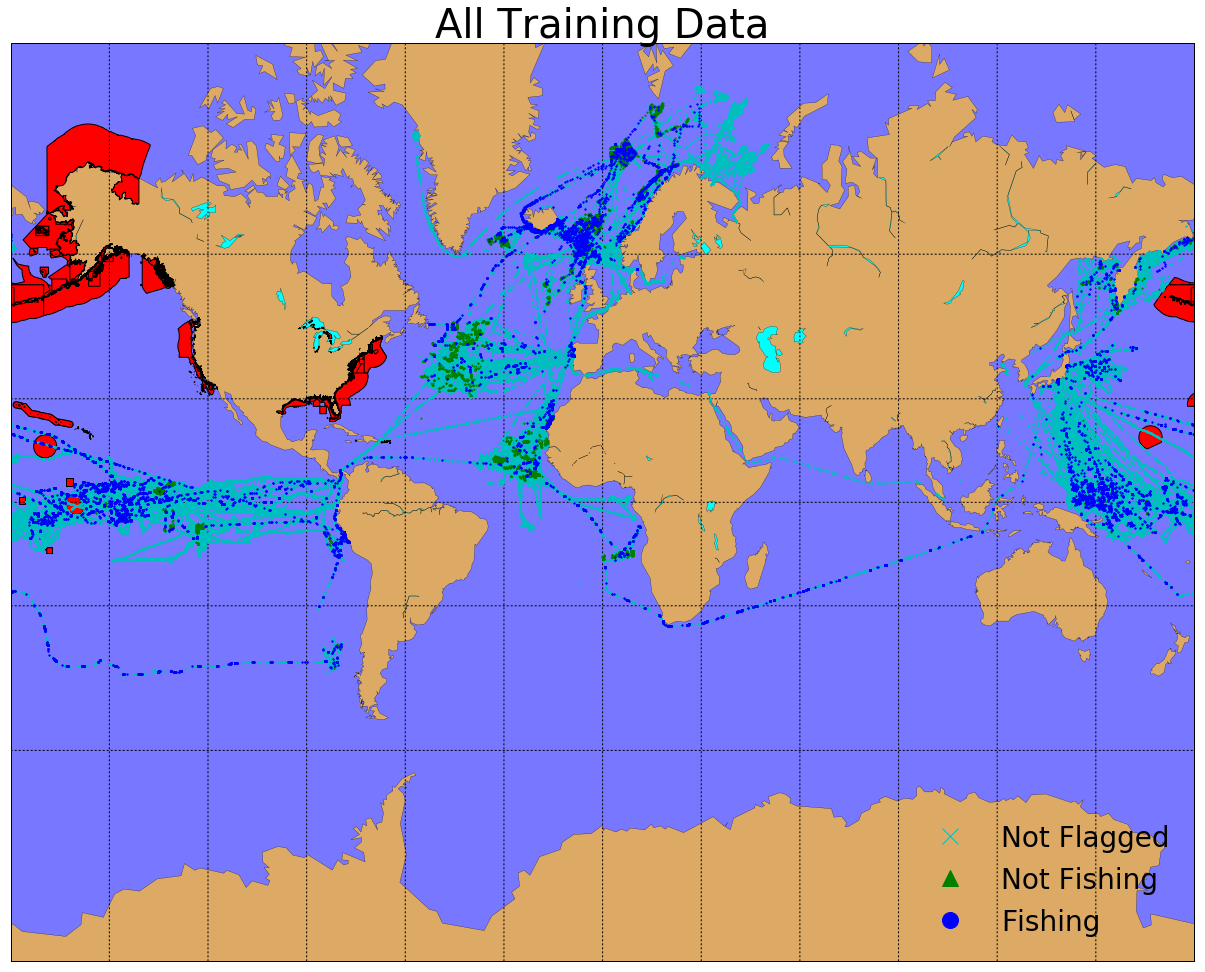

In [12]:
#insert graphing codes
all_data.dropna()
all_data.drop_duplicates()
#-----------------------------------------------------------------------------------------
# set up orthographic map projection with
# perspective of satellite looking down at 50N, 100W.
# use low resolution coastlines.
def setup_map(plt_, map_, ax_):
    plt_.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
    axs_ = plt_.subplot(111)
    map_ = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
                llcrnrlon=-180,urcrnrlon=180,lat_ts=50,resolution='c')
    # draw coastlines, country boundaries, fill continents.
#    map_.drawcoastlines(linewidth=0.25)
#    map_.drawcountries(linewidth=0.1)
    map_.fillcontinents(color='#ddaa66',lake_color='aqua')
    map_.drawmapboundary(fill_color='#7777ff')
    map_.drawcoastlines(linewidth=0.25)
    # draw lat/lon grid lines every 30 degrees.
    map_.drawmeridians(np.arange(0,360,30))
    map_.drawparallels(np.arange(-90,90,30))
    patches=[]

    for info, shape in zip(map.mpa_inventory_2014_public_shp_info, map.mpa_inventory_2014_public_shp):
        patches.append(Polygon(np.array(shape),True))

    ax_.add_collection(PatchCollection(patches, facecolor= 'r', edgecolor='k', linewidths=1., zorder=2))

#    patches=[]

#    for info, shape in zip(map.USMaritimeLimitsAndBoundariesSHP_info, map.USMaritimeLimitsAndBoundariesSHP):
#        patches.append(Polygon(np.array(shape),True))

#    ax_.add_collection(PatchCollection(patches, facecolor= 'r', edgecolor='k', linewidths=1., zorder=2))

#-----------------------------------------------------------------------------------------
# plot_position
#    Description: adds position data points to a figure does NOT connect data points
#    Call line Parameters
#      _plt:    figure for data
#      _axs:    axes to add data
#      _data:   data to add
#      _mkr:    marker to use for data
#      _title:  title for figure
#-----------------------------------------------------------------------------------------
def plot_position(_plt, _axs, _data, _mkr, _label):
    lon=[]
    lat=[]

    lon=_data[['lon']].as_matrix()
    lat=_data[['lat']].as_matrix()

    x,y = map(lon[:], lat[:])
    _axs.plot(x, y, _mkr, markersize=1, label=_label)
    
    
#Plot all Position data
#plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
fig = plt.figure(figsize=(20,15))
axs1 = plt.subplot(111)
axs1.set_title('US Marine Protected Areas',fontsize=40)
setup_map(plt, map, axs1)
#plt.show()

fig = plt.figure(figsize=(20,15))
axs = plt.subplot(111)
axs.set_title('All Training Data',fontsize=40)
setup_map(plt, map, axs)
plot_position(plt, axs, all_data.loc[all_data['classification']==-1], 'cx',  'Not Flagged')
plot_position(plt, axs, all_data.loc[all_data['classification']==1], 'g^',  'Not Fishing')  
plot_position(plt, axs, all_data.loc[all_data['classification']==0], 'bo',  'Fishing')
leg = axs.legend(loc=4, markerscale=16,fontsize=28, framealpha =0.0)
plt.show()



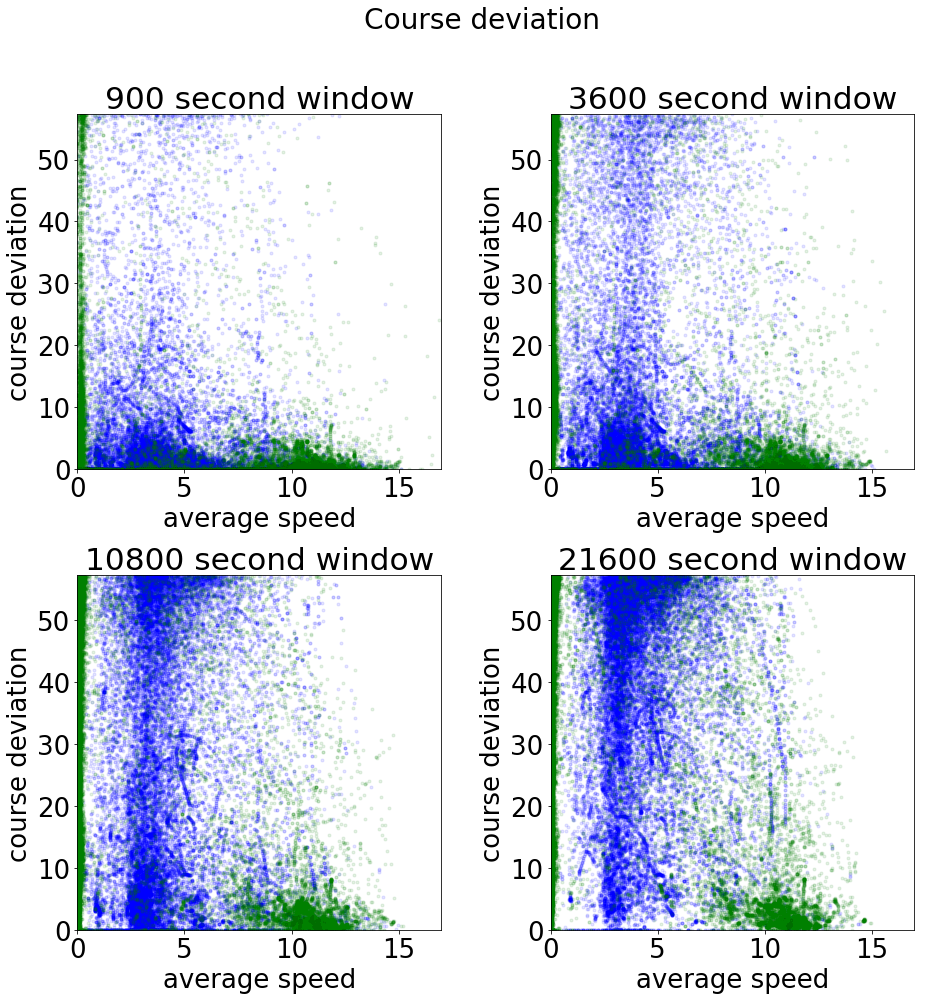

In [21]:
#Plot course deviation average speed
fig, axarr = plt.subplots(figsize=(15,15),nrows=2, ncols=2)

#ax2.set_ylim(0, 50)
    
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

labeled = all_data.loc[all_data['classification']>=0]
is_fishing = utils.is_fishy(labeled)

#Data was sampled with 900, 1800, 3600, 10800, 21600, 43200, 86400 second windows


txt_window = ['900', '3600', '21600', '86400']
txt_window = ['900', '3600', '10800', '21600']
for i, txt_window in enumerate (txt_window):
    avg_speed = 17 * (1 - labeled['measure_speedavg_' + txt_window])
    # Note that thi|s is only approximately the standard deviation of the course since we use
    # the cos/sin trick to get around branch cut at 2 Pi.
    course_deviation = labeled['measure_coursestddev_' + txt_window]  * 180 / np.pi * np.sqrt(2)

    alpha = 0.05

    axarr[i/2, i%2].set_xlabel('average speed')
    axarr[i/2, i%2].set_xlim(0, 17)
    axarr[i/2, i%2].set_ylabel('course deviation')
    axarr[i/2, i%2].set_ylim(0, 57.3)
    axarr[i/2, i%2].scatter(avg_speed[is_fishing], 
               course_deviation[is_fishing], marker='.', c='b', alpha=alpha, edgecolors='face')
    axarr[i/2, i%2].scatter(avg_speed[~is_fishing], 
               course_deviation[~is_fishing], marker='.', c='g', alpha=alpha, edgecolors='face')
    axarr[i/2, i%2].set_title(txt_window + ' second window')


txt = plt.suptitle('Course deviation',fontsize=28)
plt.show()

In [1]:
#Plot speed deviation vs average speed
fig, axarr = plt.subplots(figsize=(15,15),nrows=2, ncols=2)

#ax2.set_ylim(0, 50)
    
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

#Data was sampled with 900, 1800, 3600, 10800, 21600, 43200, 86400 second windows


txt_window = ['900', '3600', '21600', '86400']
txt_window = ['900', '3600', '10800', '21600']
for i, txt_window in enumerate (txt_window):
    avg_speed = 17 * (1 - labeled['measure_speedavg_' + txt_window])
    speed_deviation = 17 * labeled['measure_speedstddev_' + txt_window]
    alpha = 0.05

    axarr[i/2, i%2].set_xlabel('average speed')
    axarr[i/2, i%2].set_xlim(0, 17)
    axarr[i/2, i%2].set_ylabel('speed deviation')
    axarr[i/2, i%2].set_ylim(0, 9)
    axarr[i/2, i%2].scatter(avg_speed[is_fishing], 
               speed_deviation[is_fishing], marker='.', c='b', alpha=alpha, edgecolors='face')
    axarr[i/2, i%2].scatter(avg_speed[~is_fishing], 
               speed_deviation[~is_fishing], marker='.', c='g', alpha=alpha, edgecolors='face')
    axarr[i/2, i%2].set_title(txt_window + ' second window')


txt = plt.suptitle('Speed deviation',fontsize=28)
plt.show()
fig = plt.figure(figsize=(15,15))

NameError: name 'plt' is not defined

In [ ]:
#Plot course deviation and speed deviation vs average speed
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))

plt.rcParams.update({'font.size': 26})
ax1 = fig.add_subplot(221, projection='3d', )
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('average speed')
    ax.set_xlim(0, 17)
for ax in [ax1, ax3]:
    ax.set_ylabel('speed deviation')
    ax.set_ylim(0, 9)
for ax in [ax1]:
    ax.set_zlabel('course deviation')
    ax.set_zlim(0, 50)

ax2.set_ylabel('course deviation')
#ax2.set_ylim(0, 50)
    
fig.subplots_adjust(hspace=.3)
fig.subplots_adjust(wspace=.3)

labeled = all_data.loc[all_data['classification']>=0]
is_fishing = utils.is_fishy(labeled)

#Data was sampled with 900, 1800, 3600, 10800, 21600, 43200, 86400 second windows

txt_window = '21600'
avg_speed = 17 * (1 - labeled['measure_speedavg_' + txt_window])
speed_deviation = 17 * labeled['measure_speedstddev_' + txt_window]
# Note that this is only approximately the standard deviation of the course since we use
# the cos/sin trick to get around branch cut at 2 Pi.
course_deviation = labeled['measure_coursestddev_' + txt_window]  * 180 / np.pi * np.sqrt(2)

alpha = 0.05

ax1.scatter(avg_speed[is_fishing], 
           speed_deviation[is_fishing], 
           course_deviation[is_fishing], marker='.', c='b', alpha=alpha, edgecolors='face')
ax1.scatter(avg_speed[~is_fishing], 
           speed_deviation[~is_fishing], 
           course_deviation[~is_fishing], marker='.', c='g', alpha=alpha, edgecolors='face')

ax2.scatter(avg_speed[is_fishing], 
           course_deviation[is_fishing], marker='.', c='b', alpha=alpha, edgecolors='face')
ax2.scatter(avg_speed[~is_fishing], 
           course_deviation[~is_fishing], marker='.', c='g', alpha=alpha, edgecolors='face')


ax3.scatter(avg_speed[is_fishing], 
           speed_deviation[is_fishing], marker='.', c='b', alpha=alpha, edgecolors='face')
ax3.scatter(avg_speed[~is_fishing], 
           speed_deviation[~is_fishing], marker='.', c='g', alpha=alpha, edgecolors='face')


txt = plt.suptitle('All (' + txt_window + ' second window)',fontsize=40)
plt.show()

In [15]:
speed_deviation[is_fishing].describe()
avg_speed[is_fishing].describe()

count    944.000000
mean       7.504650
std        3.879371
min        0.278431
25%        4.100000
50%        7.840789
75%       11.224652
max       13.620000
Name: measure_speedavg_21600, dtype: float64

<h2>Prepare Data for Logistic Regression</h2>

In [14]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('classification ~ measure_speedstddev_900 \
                 + measure_coursestddev_900 + measure_courseavg_900 + measure_speedavg_900 + measure_pos_900 \
                 + measure_speedstddev_1800 + measure_coursestddev_1800 + measure_courseavg_1800 + measure_speedavg_1800 + measure_pos_1800 \
                 + measure_speedstddev_3600 + measure_coursestddev_3600 + measure_courseavg_3600 + measure_speedavg_3600 + measure_pos_3600 \
                 + measure_speedstddev_10800 + measure_coursestddev_10800 + measure_courseavg_10800 + measure_speedavg_10800 + measure_pos_10800 \
                 + measure_speedstddev_21600 + measure_coursestddev_21600 + measure_courseavg_21600 + measure_speedavg_21600 + measure_pos_21600 \
                 + measure_speedstddev_43200 + measure_coursestddev_43200 + measure_courseavg_43200 + measure_speedavg_43200 + measure_pos_43200 \
                 + measure_speedstddev_86400 + measure_coursestddev_86400 + measure_courseavg_86400 + measure_speedavg_86400 + measure_pos_86400', 
                 longliner_data, return_type="dataframe")
print X.columns
y = np.ravel(y)

Index([u'Intercept', u'measure_speedstddev_900', u'measure_coursestddev_900',
       u'measure_courseavg_900', u'measure_speedavg_900', u'measure_pos_900',
       u'measure_speedstddev_1800', u'measure_coursestddev_1800',
       u'measure_courseavg_1800', u'measure_speedavg_1800',
       u'measure_pos_1800', u'measure_speedstddev_3600',
       u'measure_coursestddev_3600', u'measure_courseavg_3600',
       u'measure_speedavg_3600', u'measure_pos_3600',
       u'measure_speedstddev_10800', u'measure_coursestddev_10800',
       u'measure_courseavg_10800', u'measure_speedavg_10800',
       u'measure_pos_10800', u'measure_speedstddev_21600',
       u'measure_coursestddev_21600', u'measure_courseavg_21600',
       u'measure_speedavg_21600', u'measure_pos_21600',
       u'measure_speedstddev_43200', u'measure_coursestddev_43200',
       u'measure_courseavg_43200', u'measure_speedavg_43200',
       u'measure_pos_43200', u'measure_speedstddev_86400',
       u'measure_coursestddev_86400', u'mea

In [16]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
frames=[longliner_data, trawl_data, ps_data]
frames=[ longliner_data, trawl_data]
all_data = pd.concat(frames).copy()

#drop unknown fishing points
all_data['classification'].astype(int)
all_data = all_data[all_data['classification'] != -1]

#drop duplicate rows
all_data.drop_duplicates()

fig = plt.figure(figsize=(15,15))

y0, X0 = dmatrices('classification ~ speed \
                  + course + lat + lon', all_data, return_type="dataframe")

y1, X1 = dmatrices('classification ~ measure_speedstddev_900 + measure_coursestddev_900 \
                    + measure_courseavg_900 + measure_speedavg_900 +  measure_pos_900 \
                    +  measure_pos_900', all_data, return_type="dataframe")

y2, X2 = dmatrices('classification ~ measure_speedstddev_3600 + measure_coursestddev_3600 \
                    + measure_courseavg_3600 + measure_speedavg_3600 +  measure_pos_3600 \
                    +  measure_pos_3600', all_data, return_type="dataframe")

y3, X3 = dmatrices('classification ~ measure_speedstddev_10800 + measure_coursestddev_10800 \
                    + measure_courseavg_10800 + measure_speedavg_10800 +  measure_pos_10800 \
                    +  measure_pos_10800', all_data, return_type="dataframe")

y4, X4 = dmatrices('classification ~ measure_speedstddev_21600 + measure_coursestddev_21600 \
                    + measure_courseavg_21600 + measure_speedavg_21600 +  measure_pos_21600 \
                    +  measure_pos_21600', all_data, return_type="dataframe")

y5, X5 = dmatrices('classification ~ measure_speedstddev_43200 + measure_coursestddev_43200 \
                    + measure_courseavg_43200 + measure_speedavg_43200 +  measure_pos_43200 \
                    +  measure_pos_43200', all_data, return_type="dataframe")

y6, X6 = dmatrices('classification ~ measure_speedstddev_86400 + measure_coursestddev_86400 \
                    + measure_courseavg_86400 + measure_speedavg_86400 +  measure_pos_86400 \
                    +  measure_pos_86400', all_data, return_type="dataframe")

xs = [X0, X1, X2, X3, X4, X5, X6]
ys = [y0, y1, y2, y3, y4, y5, y6]
labels = ['AIS', 'W900', 'W3600', 'W10800', 'W21600', 'W43200', 'W86400' ]
for i, X in enumerate (xs):
    y = np.ravel(ys[i])

    # evaluate the model by splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(xs[i], ys[i], test_size=0.3, random_state=0)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # generate class probabilities
    predicted = model.predict(X_test)

    # generate class probabilities
    probs = model.predict_proba(X_test)

    # generate evaluation metrics
    print metrics.accuracy_score(y_test, predicted)
    print metrics.roc_auc_score(y_test, probs[:, 1])

    print metrics.confusion_matrix(y_test, predicted)
    print metrics.classification_report(y_test, predicted)

    # evaluate the model using 10-fold cross-validation
    scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
    print scores
    print scores.mean()
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC_{} = %0.2f'.format(labels[i]) % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')



/Users/edwardkerrigan/.virtualenvs/illegal-fishing2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.694600406164
0.723436350719
[[11382  5604]
 [ 4622 11876]]
             precision    recall  f1-score   support

        0.0       0.71      0.67      0.69     16986
        1.0       0.68      0.72      0.70     16498

avg / total       0.70      0.69      0.69     33484

[ 0.25989966  0.35826913  0.68103217  0.70504435  0.58139952  0.54018457
  0.54090135  0.94552459  0.97365827  0.77385539]
0.635976900199
0.621371401266
0.670388863736
[[11886  5100]
 [ 7578  8920]]
             precision    recall  f1-score   support

        0.0       0.61      0.70      0.65     16986
        1.0       0.64      0.54      0.58     16498

avg / total       0.62      0.62      0.62     33484

[ 0.40727468  0.49901451  0.64877699  0.66723412  0.47764537  0.41080548
  0.65684078  0.69411343  0.69805573  0.56150883]
0.572126993198
0.634243220643
0.683674194362
[[12107  4879]
 [ 7368  9130]]
             precision    recall  f1-score   support

        0.0       0.62      0.71      0.66     16986
    

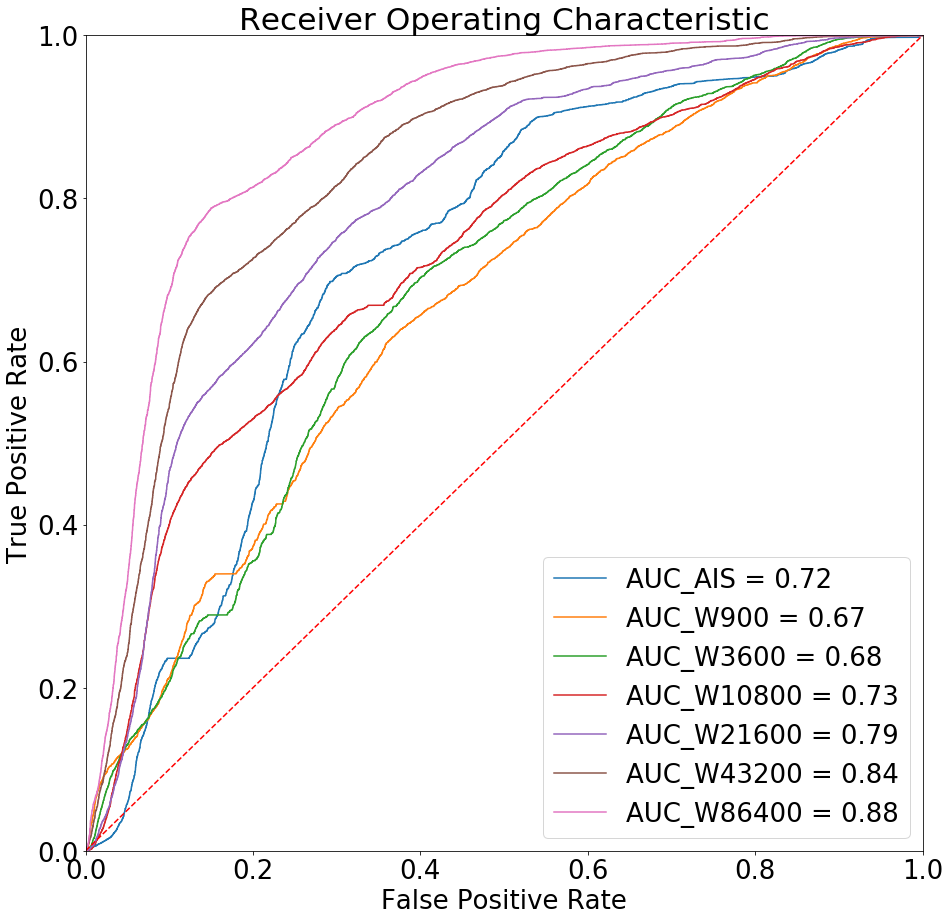

In [17]:
plt.show()